# Log Analytics - USX Manager (REST Calls)

This notebook provides a quick summary analytics on the REST api calls made to an USX Management Server. 

The input to this notebook could be either usx-manager-requests.log / usxm-agent-requests.log 

In [47]:
%matplotlib inline

from IPython.core.display import HTML
from IPython.display import Image

# Libraries
import apachelog, sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as npb
import pandas as pd
import datetime as dt
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter
from seasonal import fit_seasons, adjust_seasons, fit_trend

import seaborn as sns

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [48]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

### USXM REST Calls Log

Below is the log format itself and a short description of every element:
    
    format = r'%h  %l %u %t \"%r\" %>s %b \"%i\" \"%{User-Agent}i\" %T'
    
    %V          - the server name according to the UseCanonicalName setting
    %h          - remote host (ie the client IP)
    %l          - identity of the user determined by identd (not usually used since not reliable)
    %u          - user name determined by HTTP authentication
    %t          - time the server finished processing the request.
    %r          - request line from the client. ("GET / HTTP/1.0")
    %>s         - status code sent from the server to the client (200, 404 etc.)
    %b          - size of the response to the client (in bytes)
    \"%i\"      - Referer is the page that linked to this URL.
    User-agent  - the browser identification string
    %T          - Apache request time  

#### Sample Log Statement

10.19.14.134 - - [26/Aug/2016:06:32:21 +0000] "GET /usxmanager/metrics?target=alias(summarize(*.%7BUSX_8b8419cf-9193-330e-a7f6-f8a9bbcfdc3b%7D.VolumeCapOffloadCollector.%7BCapacity_Offload_Percent%7D,%225min%22,%22avg%22),%22Deduplication%20Ratio%20(%25)%22)&from=-1hours&until=now&format=json&lineMode=connected&noCache=true&width=500&height=250&jsonp=jQuery1110014890684454986425_1472191760944&_=1472191761024 HTTP/1.1" 200 - "https://10.19.12.100:8443/index.html" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36" 24


In [49]:
# Functions
def dash2nan(x):
    if x == '-':
        x = np.nan
    else:
        x = int(x)/1024
    return x

def gmet(x):
    x = x.split()
    return x[0]

def read_web_log(filename):
    # Create format
    logformat =  r"%h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-agent}i\" %T"

    # Create parser
    logparser = apachelog.parser(logformat)
    
    log = open(filename).readlines()
    log_list = []
    for line in log:
       try:
          data = logparser.parse(line)
       except:
          sys.stderr.write("Unable to parse %s" % line)
       data['%t'] = data['%t'][1:12]+' '+data['%t'][13:21]+' '+data['%t'][22:27]
       log_list.append(data)
        
    # Convert to dataframe
    df = pd.DataFrame(log_list)
    
    # Rename columns
    df = df.rename(columns={'%>s': 'Status', '%b':'Size','%h':'IP', '%r':'Request', '%t': 'Time'})
    
    # Convert Time column to datetime format and make an index out of it (pop will drop original Time column):
    df.index = pd.to_datetime(df.pop('Time'))
    
    # Convert Status variable to int:
    df['Status'] = df['Status'].astype('int')

    # Convert '-' to NA for b column
    df['Size'] = df['Size'].apply(dash2nan)
    
    # Populate method columns
    df['Method'] = df.Request.apply(gmet)
    
    return df[['Status', 'IP', 'Method', 'Request','Size']]

def get_method_ip_stats(df):
    method_ip = df.groupby(['Method', 'IP']).size()
    return method_ip

def get_ip_status_stats(df):
    ips_status = df.groupby(['IP', 'Status']).size()
    ips_status.sort_values(inplace=True, ascending=False)
    return ips_status

def get_status_details(df, t_span='H'):
    df_404 = df['Status'][df['Status'] == 404].resample(t_span, how='count')
    df_403 = df['Status'][df['Status'] == 403].resample(t_span, how='count')
    df_301 = df['Status'][df['Status'] == 301].resample(t_span, how='count')
    df_304 = df['Status'][df['Status'] == 304].resample(t_span, how='count')
    df_200 = df['Status'][df['Status'] == 200].resample(t_span, how='count')
    df_500 = df['Status'][df['Status'] == 500].resample(t_span, how='count')
    status_df = pd.DataFrame({'OK':df_200, 'ServerError':df_500, 'NotFound':df_404, 'UnAuthorized':df_403,})
    status_df.fillna(0, inplace=True)
    return status_df


In [50]:
print("Reading the log file...Printing last few log statements in table form")
df = read_web_log('data/usxm-server-request.log')
df.tail()

Reading the log file...Printing last few log statements in table form


,Status,IP,Method,Request,Size
Time,,,,,
2016-09-02 20:05:01,200,10.19.12.100,GET,GET /usxmanager/usxmanager HTTP/1.1,2
2016-09-02 20:05:05,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/servicevm/contai...,0
2016-09-02 20:05:05,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/volume/container...,NaN
2016-09-02 20:05:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-02 20:06:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0


### REST API Calls stats....

**Note on API Method Types:** -

1. **GET** = Get Data
2. **POST** = Create Config Data
3. **PUT** = Update Config Data
4. **DELETE** = Delete Config


Method  IP          
DELETE  10.19.15.82         1
GET     10.1.0.70          15
        10.15.2.56         52
        10.15.2.64         16
        10.19.12.100     6577
        10.19.14.134      176
        10.19.14.28       453
        10.19.15.82       159
        127.0.0.1        7131
POST    10.19.12.100      184
        127.0.0.1           8
PUT     10.15.2.64          1
        10.19.14.134        1
        10.19.14.28         2
        10.19.15.82         2
        127.0.0.1       11084
dtype: int64


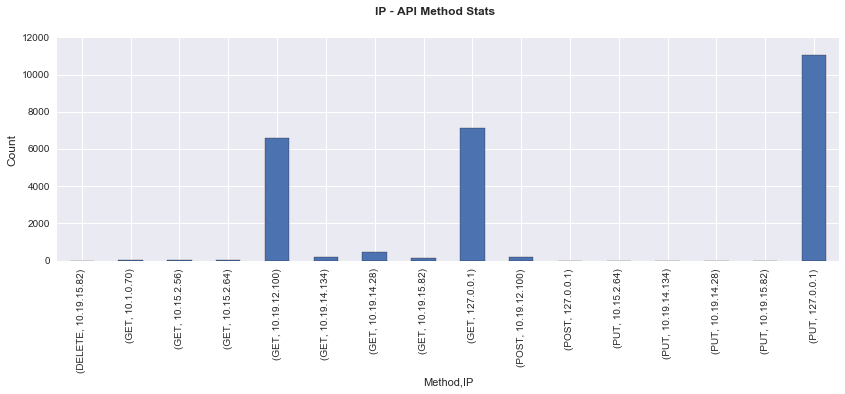

In [51]:
method_ip = get_method_ip_stats(df)
fig = plt.figure(figsize=(14, 4))
fig.suptitle('IP - API Method Stats', fontsize=12, fontweight='bold', verticalalignment='baseline')
g= method_ip.plot(kind='bar')
g.set_ylabel("Count", fontsize=12)
print(method_ip)

**API Calls Status Codes:**    
* 200  -      Success   - OK 
* 502  -      Failure   - Bad Gateway
* 499  -      Failure   - Client closed request
* 304  -      Success   - Not modified
* 302  -      Success   - Found
* 404  -      Success   - Not Found
* 504  -      Failure   - Gateway timeout
* 401  -      Success   - Unauthorized
* 403  -      Success   - Forbidden
* 500  -      Failure   - Internal server error
* 400  -      Success   - Bad request
* 408  -      Success?  - Request timeout
* 405  -      Success   - Method not allowed

IP            Status
127.0.0.1     200       18223
10.19.12.100  200        6761
10.19.14.28   200         453
10.19.14.134  200         177
10.19.15.82   200         160
10.15.2.56    200          52
10.15.2.64    200          16
10.1.0.70     200          14
10.19.15.82   101           2
10.19.14.28   101           2
10.15.2.64    401           1
10.1.0.70     401           1
dtype: int64


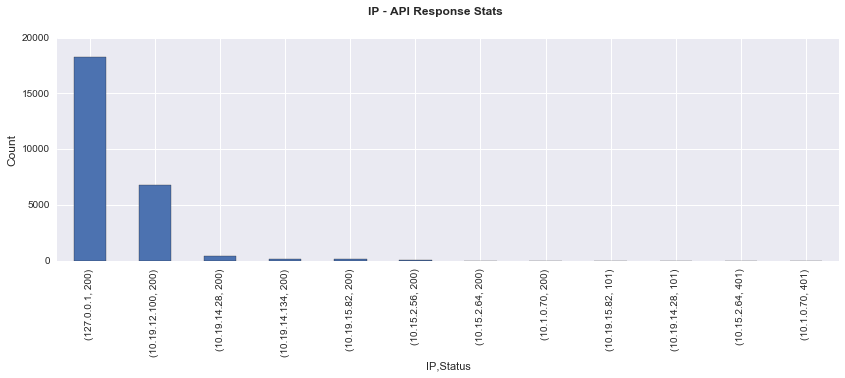

In [52]:
ips_status = get_ip_status_stats(df)
fig = plt.figure(figsize=(14, 4))
fig.suptitle('IP - API Response Stats', fontsize=12, fontweight='bold', verticalalignment='baseline')
g = ips_status.plot(kind='bar')
g.set_ylabel("Count", fontsize=12)
print(ips_status)

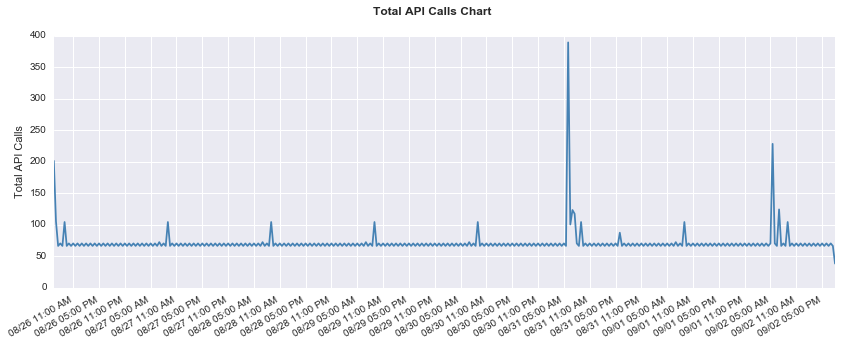

In [53]:
def create_line_plot(metric_name, series):
    '''
        Create line plot using seaborn
    '''
    # Create line chart
    fig = plt.figure(figsize=(14, 5))
    fig.suptitle(metric_name + ' Chart', fontsize=12, fontweight='bold')
    ax = plt.gca()
    ax.xaxis.set_major_locator(HourLocator(interval=6))
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d %I:%M %p')) # TimeFormat : http://strftime.org/
    plt.plot(series, color='steelblue')
    #plt.xlabel("timestamp", fontweight='bold')
    plt.ylabel(metric_name)
    plt.gcf().autofmt_xdate()
    return

df_s = df['Request'].resample('30T', how='count')
create_line_plot("Total API Calls", df_s)

Successful and Failure API calls aggregated on hourly scale...


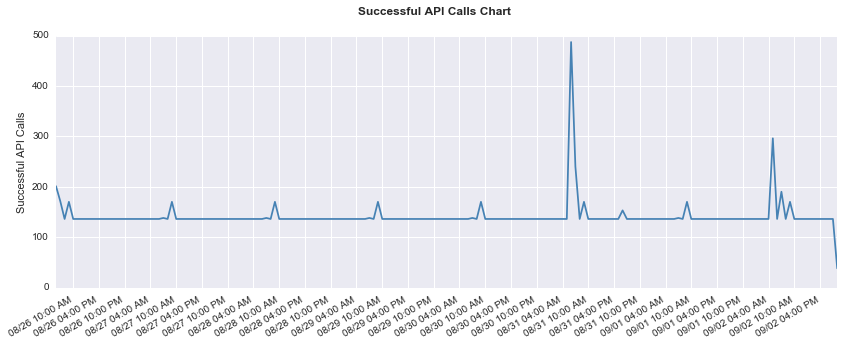

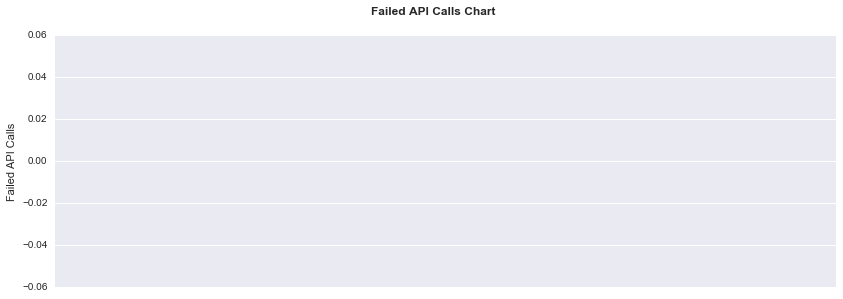

In [54]:
print("Successful and Failure API calls aggregated on hourly scale...")
success_df = df[df['Status'].isin([200, 304, 302, 404, 301, 401, 403, 206, 444, 400, 408, 405])].resample("1H", how='count')
fail_df = df[df['Status'].isin([502, 499, 504, 500, 444])].resample("1H", how='count')

create_line_plot("Successful API Calls", success_df['Status'])
create_line_plot("Failed API Calls", fail_df['Status'])

### Top REST API Calls...

In [55]:
df['Request'].value_counts().head(10) 
#counts = df[df['Request'].str.contains('GET')]['Status'].value_counts()

PUT /usxmanager/services/INSIGHT/10.19.12.100 HTTP/1.1                                                                      10894
GET /usxmanager/usxmanager HTTP/1.1                                                                                          4385
GET /usxmanager/usx/inventory/servicevm/containers?sortby=uuid&order=ascend&page=0&pagesize=100&composite=false HTTP/1.1     4358
GET /usxmanager/usx/inventory/volume/containers?sortby=uuid&order=ascend&page=0&pagesize=100&composite=false HTTP/1.1        4358
GET /usxmanager/services/INSIGHT/10.19.12.100 HTTP/1.1                                                                        190
GET /usxmanager/policies/USX_cb782f36-17ba-3d1c-bdaa-cc2cb4415bee HTTP/1.1                                                    182
PUT /usxmanager/model/jobstatus HTTP/1.1                                                                                      182
GET /usxmanager/license HTTP/1.1                                                          

### REST API calls response status over time...

Below provides REST api calls response status & count **aggregated at hourly** scale....

                     NotFound   OK  ServerError  UnAuthorized
Time                                                         
2016-09-02 13:00:00         0  136            0             0
2016-09-02 14:00:00         0  136            0             0
2016-09-02 15:00:00         0  136            0             0
2016-09-02 16:00:00         0  136            0             0
2016-09-02 17:00:00         0  136            0             0
2016-09-02 18:00:00         0  136            0             0
2016-09-02 19:00:00         0  136            0             0
2016-09-02 20:00:00         0   37            0             0


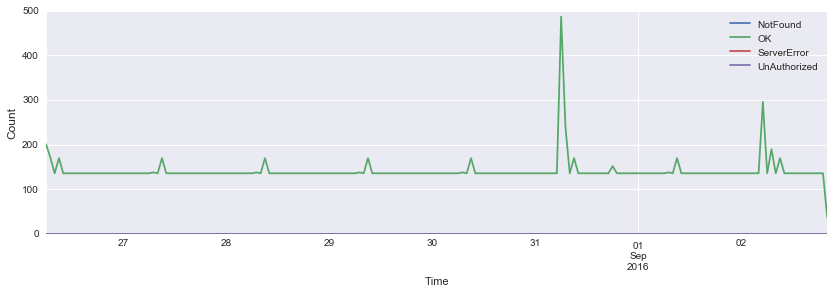

In [56]:
status_df = get_status_details(df)
g = status_df.plot(kind='line', figsize=(14, 4))
g.set_ylabel("Count", fontsize=12)
print(status_df.tail(8))
#status_df.tail(48)[['OK', 'Not Found','Server Error', 'Forbidden']].plot(kind='barh', stacked=True, figsize=(10, 10))

Below provides Rest API calls frequency sampled at 5 minute intervals....

### REST API requests whose response size is larger than 2 KB

How many rest API calls whose response size is > 2 KB?

Size   Count
4    182
3     24
Name: Size, dtype: int64


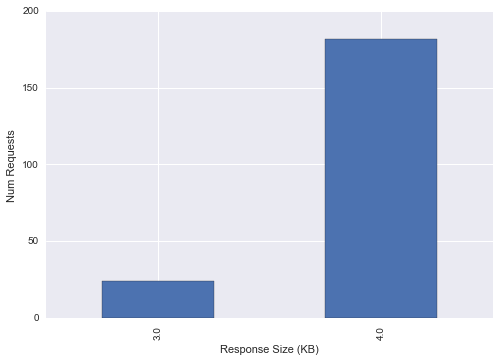

In [57]:
# Choose all requests with the size of the response larger than 2 Kb (remember we convert bytes to KB):
df_2kb = df[df['Size']> 2]

print("Size   Count")
print(df_2kb['Size'].value_counts())
grouped_status = df_2kb.groupby('Size')
g=grouped_status.size().plot(kind='bar')
g.set_xlabel("Response Size (KB)")
g.set_ylabel("Num Requests")

Which nodes are invoking these rest api calls and count of calls?

IPAddress   Count
127.0.0.1    206
Name: IP, dtype: int64


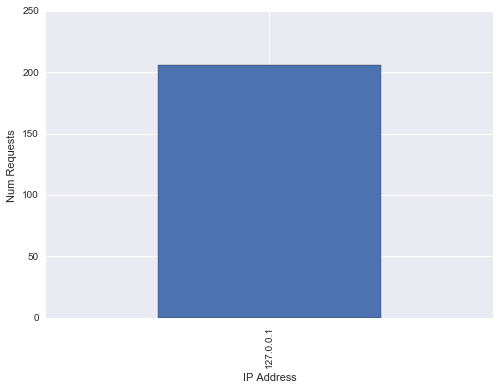

In [58]:
print("IPAddress   Count")
print(df_2kb['IP'].value_counts())
grouped_status2 = df_2kb.groupby('IP')
g=grouped_status2.size().plot(kind='bar')
g.set_xlabel("IP Address")
g.set_ylabel("Num Requests")

What are the status of these large rest response api calls and count?

Status Count
200    206
Name: Status, dtype: int64


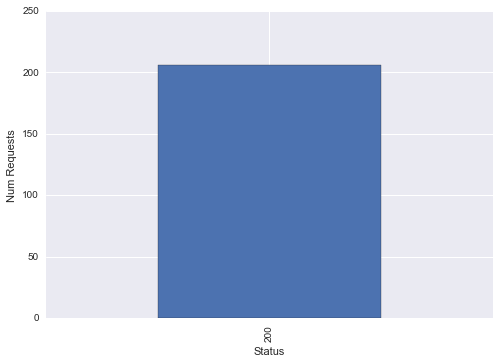

In [59]:
print("Status Count")
print(df_2kb['Status'].value_counts())
grouped_status1 = df_2kb.groupby('Status')
g=grouped_status1.size().plot(kind='bar')
g.set_xlabel("Status")
g.set_ylabel("Num Requests")

In [60]:
print("Finally top api requests whose response size > 2 KB")
df_2kb['Request'].value_counts().head(5) 

Finally top api requests whose response size > 2 KB


GET /usxmanager/license HTTP/1.1                                              182
GET /usxmanager/policies/USX_f328fe59-1b30-37d0-ad62-599a6a7b6fc3 HTTP/1.1     24
Name: Request, dtype: int64

### Additional Investigations...

We have too many calls from 127.0.0.1 (see 1st section for details). What are the calls?

In [61]:
print("Printing last 30 calls from 127.0.0.1...")
df[df.IP =='127.0.0.1'].tail(30)

Printing last 30 calls from 127.0.0.1...


,Status,IP,Method,Request,Size
Time,,,,,
2016-09-02 19:50:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-02 19:51:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-02 19:52:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-02 19:53:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-02 19:54:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-02 19:55:02,200,127.0.0.1,GET,GET /usxmanager/usxmanager HTTP/1.1,2
2016-09-02 19:55:06,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/servicevm/contai...,0
2016-09-02 19:55:06,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/volume/container...,NaN
2016-09-02 19:55:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
